In [76]:
import boto3
import botocore
import sagemaker
import sys


bucket = 'ads-bucket-senichol'   # <--- specify a bucket you have access to
prefix = 'kaggle-crypto-data/RCF'

daves_bucket = 'sagemaker-davidrob'
daves_prefix = 'group-project/bitcoin'

execution_role = sagemaker.get_execution_role()


# check if the bucket exists
try:
    boto3.Session().client('s3').head_bucket(Bucket=bucket)
except botocore.exceptions.ParamValidationError as e:
    print('Hey! You either forgot to specify your S3 bucket'
          ' or you gave your bucket an invalid name!')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == '403':
        print("Hey! You don't have permission to access the bucket, {}.".format(bucket))
    elif e.response['Error']['Code'] == '404':
        print("Hey! Your bucket, {}, doesn't exist!".format(bucket))
    else:
        raise
else:
    print('Training input/output will be stored in: s3://{}/{}'.format(bucket, prefix))

Training input/output will be stored in: s3://ads-bucket-senichol/kaggle-crypto-data/RCF


In [3]:
# Step 1: get the bitcoin minute-by-minute data from kaggle (one way or another)
# https://www.kaggle.com/mczielinski/bitcoin-historical-data
# https://www.kaggle.com/mczielinski/bitcoin-historical-data#bitstampUSD_1-min_data_2012-01-01_to_2018-06-27.csv
    
#import pandas as pd
#!pip install kaggle
#!kaggle datasets download -d mczielinski/bitcoin-historical-data
#!mkdir bitcoin-historical-data
#!mv bitcoin-historical-data.zip /bitcoin-historical-data
#!unzip -a /bitcoin-historical-data/bitcoin-historical-data.zip
#df = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2018-06-27.csv', encoding="ISO-8859-1", low_memory=False)

# Either run the lines above this comment or do something like the lines below.

# I saved and unzipped the file to my instance via the above lines, but ran into some difficulty reading it. 
# I tried messing with the path a bit, and then gave up and just read the data from my own S3 bucket
import pandas as pd
import io
s3 = boto3.client('s3')
raw_data = s3.get_object(Bucket='sagemaker-davidrob', Key=f'group-project/bitcoin/bitstampUSD_1-min_data_2012-01-01_to_2018-06-27.csv')
df = pd.read_csv(io.BytesIO(raw_data['Body'].read()), encoding="ISO-8859-1", low_memory=False)

In [22]:
# Step 2: Add day and hour data elements to the dataframe so we can group by days and hours in later analysis

from datetime import datetime
# create various date formats for grouping later on
df['Time'] = pd.to_datetime(df['Timestamp'], unit = 's', infer_datetime_format = 'True')
df['Date'] = df['Time'].values.astype('datetime64[D]')
df['Hour'] = df['Time'].values.astype('datetime64[h]')
df['Minute'] = df['Time'].values.astype('datetime64[m]')

df.drop(columns=['Time', 'Timestamp'])

# reality check - make sure the dataframe looks right so far.
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Time,Date,Hour,Minute
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 07:52:00,2011-12-31,2011-12-31 07:00:00,2011-12-31 07:52:00
1,1325317980,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 07:53:00,2011-12-31,2011-12-31 07:00:00,2011-12-31 07:53:00
2,1325318040,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 07:54:00,2011-12-31,2011-12-31 07:00:00,2011-12-31 07:54:00
3,1325318100,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 07:55:00,2011-12-31,2011-12-31 07:00:00,2011-12-31 07:55:00
4,1325318160,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 07:56:00,2011-12-31,2011-12-31 07:00:00,2011-12-31 07:56:00


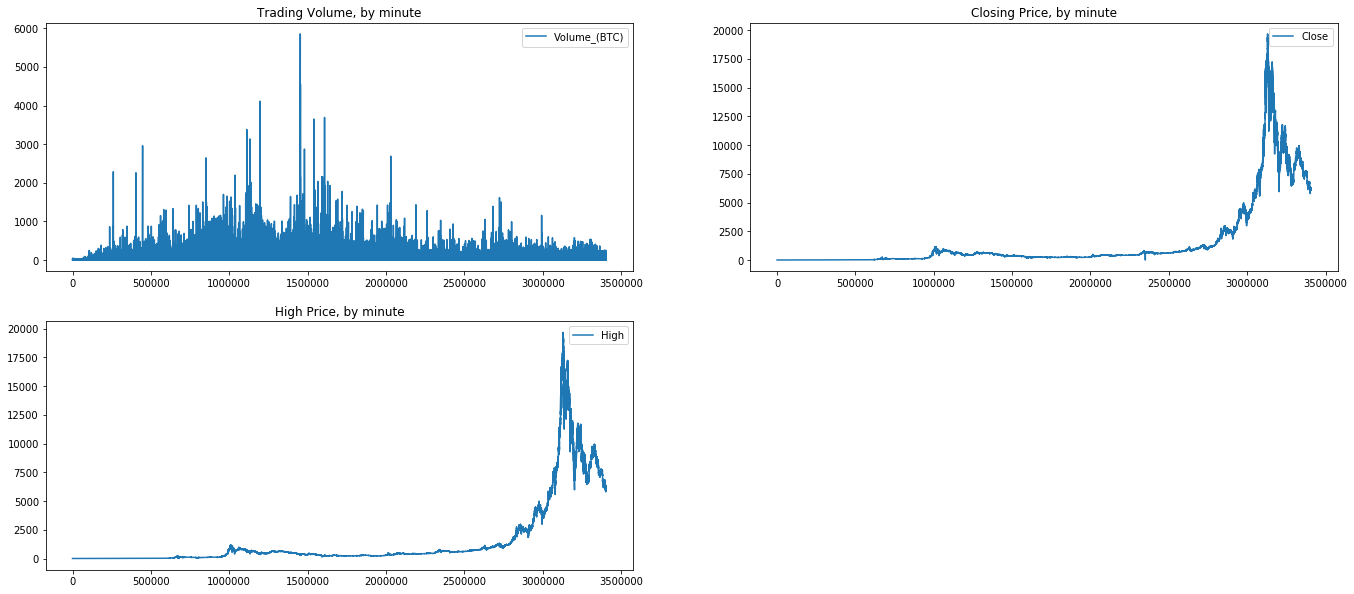

In [6]:
# Step 3: Show some charts
import matplotlib.pyplot as plt
# plot the minute-by-minute data
plt.subplot(221)
df['Volume_(BTC)'].plot(legend=True)
plt.title('Trading Volume, by minute')

plt.subplot(222)
df['Close'].plot( legend=True)
plt.title('Closing Price, by minute')

plt.subplot(223)
df['High'].plot(legend=True)
plt.title('High Price, by minute')

plt.subplots_adjust(left=0.01, right = 3, wspace=0.2, bottom = 0.1, top=2)

plt.show()


In [9]:
# Step 4: group minute-by-minute data points by day to view the standard deviation of the features in the array below
df_std = df.groupby(['Date'])['Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Weighted_Price'].std()
# removing '2018-06-27' because I know these values contain NA values and can't be used for training data.
df_std = df_std[df_std.index != '2018-06-27']

# only 2,367 data elements in this dataframe
print(df_std.shape)
df_std.head()

(2367, 6)


,Open,High,Low,Close,Volume_(BTC),Weighted_Price
Date,,,,,,
2011-12-31,0.094181,0.094229,0.094181,0.094229,11.978798,0.094193
2012-01-01,0.139856,0.139856,0.139856,0.139856,4.094532,0.139856
2012-01-02,0.000000,0.000000,0.000000,0.000000,3.313474,0.000000
2012-01-03,0.145733,0.145733,0.145733,0.145733,9.048262,0.145733
2012-01-04,0.189487,0.252133,0.189487,0.252133,15.589931,0.210158


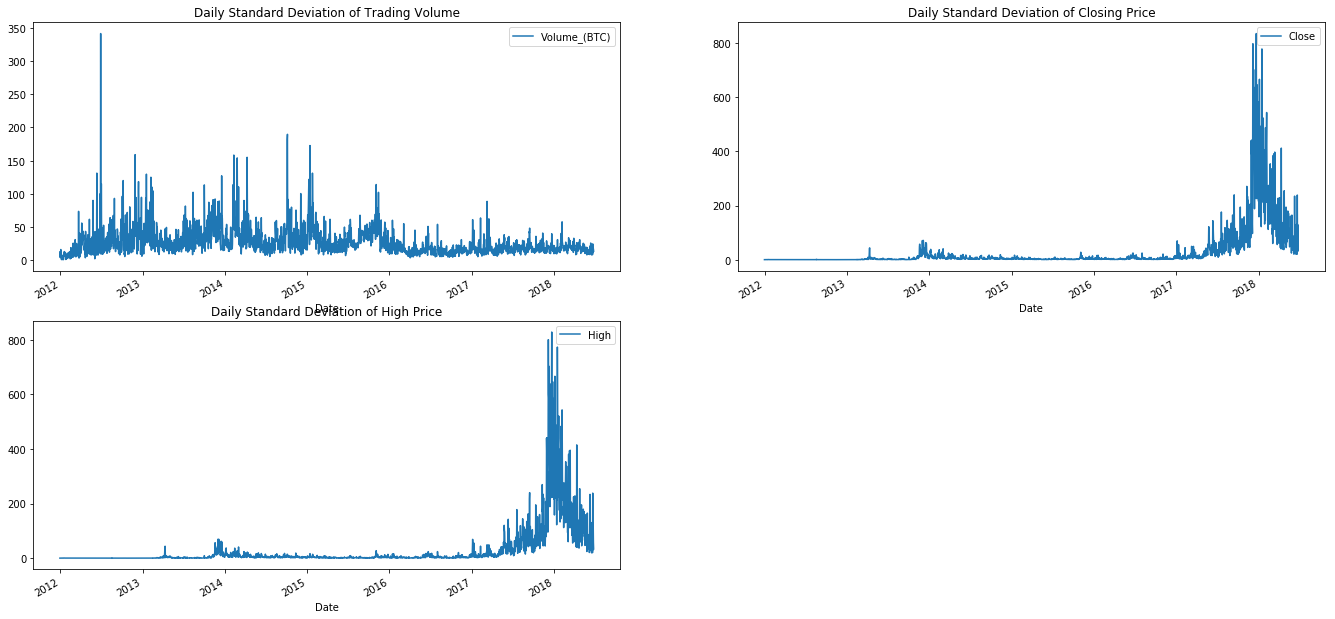

In [11]:
# Step 5: same charts, but using the standard deviation data when minute-level daata is grouped by day
# plotting the daily volatility measures
plt.subplot(221)
df_std['Volume_(BTC)'].plot(legend=True)
plt.title('Daily Standard Deviation of Trading Volume')

plt.subplot(222)
df_std['Close'].plot(legend=True)
plt.title('Daily Standard Deviation of Closing Price')

plt.subplot(223)
df_std['High'].plot(legend=True)
plt.title('Daily Standard Deviation of High Price')

plt.subplots_adjust(left=0.01, right = 3, wspace=0.2, bottom = 0.1, top=2)

plt.show()


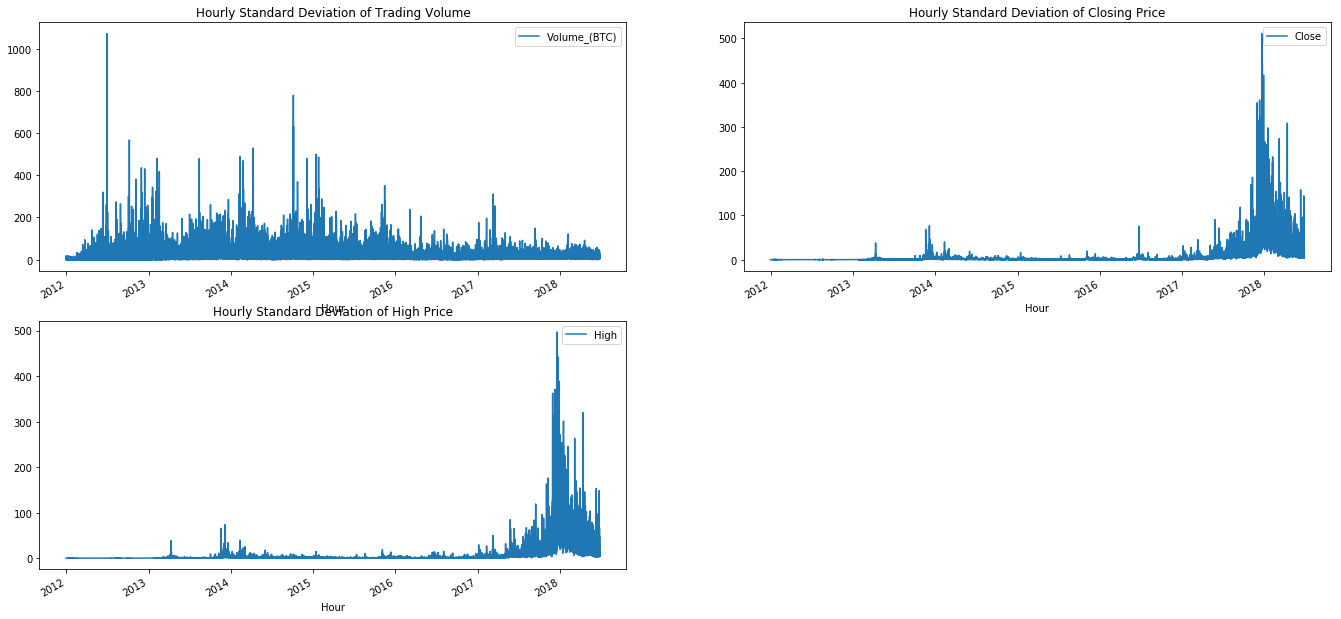

In [73]:
# Step 6: same charts, but using the standard deviation data when minute-level daata is grouped by hour

#df_std_hourly = df.groupby(['Hour']).std()
df_std_hourly = df.groupby(['Hour'])['Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Weighted_Price'].std()
#df_std_hourly = df_std_hourly[df_std_hourly.index > '2012-06-20']  # standard deviations are all zero before this date

# plots
plt.subplot(221)
df_std_hourly['Volume_(BTC)'].plot(legend=True)
plt.title('Hourly Standard Deviation of Trading Volume')

plt.subplot(222)
df_std_hourly['Close'].plot(legend=True)
plt.title('Hourly Standard Deviation of Closing Price')

plt.subplot(223)
df_std_hourly['High'].plot(legend=True)
plt.title('Hourly Standard Deviation of High Price')

plt.subplots_adjust(left=0.01, right = 3, wspace=0.2, bottom = 0.1, top=2)

plt.show()

In [77]:
# Step 7: create the random cut forest object, defining two parameters: num_samples_per_tree and num_trees.
# This will generate a model using the daily standard deviation dataframe

# I don't have the ability to write to Scott's S3 bucket, so I am writing to my own for now.

from sagemaker import RandomCutForest

session = sagemaker.Session()

# specify general training job information
rcf = RandomCutForest(role=execution_role,
                      train_instance_count=1,
                      train_instance_type='ml.c5.xlarge',
                      data_location='s3://{}/{}/'.format(daves_bucket, daves_prefix),
                      output_path='s3://{}/{}/output'.format(daves_bucket, daves_prefix),
                      num_samples_per_tree=200,
                      num_trees=500)
# automatically upload the training data to S3 and run the training job

rcf.fit(rcf.record_set(df_std.values))

INFO:sagemaker:Creating training-job with name: randomcutforest-2018-09-30-03-34-34-791


2018-09-30 03:34:35 Starting - Starting the training job...
Launching requested ML instances......
Preparing the instances for training...
2018-09-30 03:36:16 Downloading - Downloading input data
2018-09-30 03:36:24 Training - Downloading the training image...
Training image download completed. Training in progress..
Docker entrypoint called with argument(s): train
[09/30/2018 03:37:03 INFO 139811319473984] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_ftp_port': 8999, u'num_samples_per_tree': 256, u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'_kvstore': u'dist_async', u'force_dense': u'true', u'epochs': 1, u'num_trees': 100, u'eval_metrics': [u'accuracy', u'precision_recall_fscore'], u'_num_kv_servers': u'auto', u'mini_batch_size': 1000}
[09/30/2018 03:37:03 INFO 139811319473984] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'mini_batch_size':


2018-09-30 03:37:08 Uploading - Uploading generated training model
2018-09-30 03:37:14 Completed - Training job completed
Billable seconds: 58


It takes a few minutes for the training instance to become available.

Don't worry about the output text above turning red. That's not an indication of an error.

You can view the status of a training job using the AWS SageMaker console. Just click on the "Jobs" tab and select training job matching the training job name, below.
https://console.aws.amazon.com/sagemaker/home?region=us-east-1#/jobs

If you see the message 

> `Billable seconds: nn`

at the end of the output in the box above, that means training successfully completed and the output RCF model was stored in the specified output path.

Building the model with the daily standard deviation data took about 5 minutes and 60 billable seconds.

In [79]:
# Step 8: another reality check, confirming the name of the new training job. Not very helpful, atcually.
print('Training job name: {}'.format(rcf.latest_training_job.job_name))

Training job name: randomcutforest-2018-09-30-03-34-34-791


In [80]:
# Step 9:  spin up endpoint instances for generating anamaly scores. 
# At this point, we're just starting the endpoint machines, which takes some time.

rcf_inference = rcf.deploy(
    initial_instance_count=1,
    instance_type='ml.c5.xlarge',
)

INFO:sagemaker:Creating model with name: randomcutforest-2018-09-30-03-40-11-008
INFO:sagemaker:Creating endpoint with name randomcutforest-2018-09-30-03-34-34-791


--------------------------------------------------------------------------!

Building the endpoint also takes some time. 5 or 10 minutes.

You can confirm the endpoint configuration and status by navigating to the "Endpoints" tab in the AWS SageMaker console and selecting the endpoint matching the endpoint name, below.  (https://console.aws.amazon.com/sagemaker/home?region=us-east-1#/endpoints)

In [81]:
# Step 10: getting ready to send data to the endpoint so that it will spit out anomaly scores

from sagemaker.predictor import csv_serializer, json_deserializer

rcf_inference.content_type = 'text/csv'
rcf_inference.serializer = csv_serializer
rcf_inference.accept = 'application/json'
rcf_inference.deserializer = json_deserializer

In [82]:
# Step 11: Here we take the original data and reformat it according to the format we just specified in step 10.
df_std_numpy = df_std.as_matrix()

# reality check - what do the first few items in this array matrix like?
print(df_std_numpy[:6])

[[ 0.09418127  0.09422923  0.09418127  0.09422923 11.97879815  0.09419305]
 [ 0.1398558   0.1398558   0.1398558   0.1398558   4.0945321   0.1398558 ]
 [ 0.          0.          0.          0.          3.31347408  0.        ]
 [ 0.14573289  0.14573289  0.14573289  0.14573289  9.04826165  0.14573289]
 [ 0.18948707  0.25213305  0.18948707  0.25213305 15.58993063  0.2101581 ]
 [ 0.36764586  0.33949027  0.36764586  0.33949027 11.17254634  0.35599088]]


In [84]:
# Step 12: We generated anomaly scores for the daily std_dev records. let's look at them.

results = rcf_inference.predict(df_std_numpy)
scores = [datum['score'] for datum in results['scores']]

# add scores to daily std_dev dataframe and print first few values
df_std['score'] = pd.Series(scores, index=df_std.index)
df_std.head()

,Open,High,Low,Close,Volume_(BTC),Weighted_Price,score
Date,,,,,,,
2011-12-31,0.094181,0.094229,0.094181,0.094229,11.978798,0.094193,1.397829
2012-01-01,0.139856,0.139856,0.139856,0.139856,4.094532,0.139856,1.633006
2012-01-02,0.000000,0.000000,0.000000,0.000000,3.313474,0.000000,1.694658
2012-01-03,0.145733,0.145733,0.145733,0.145733,9.048262,0.145733,1.443003
2012-01-04,0.189487,0.252133,0.189487,0.252133,15.589931,0.210158,1.373230


In [85]:
df_std.describe()

,Open,High,Low,Close,Volume_(BTC),Weighted_Price,score
count,2367.000000,2367.000000,2367.000000,2367.000000,2367.000000,2367.000000,2367.000000
mean,28.754174,28.642632,28.852132,28.763746,26.644910,28.770256,1.949765
std,81.676950,81.325773,81.915487,81.667798,21.056891,81.685035,0.796402
min,0.000000,0.000000,0.000000,0.000000,0.236352,0.000000,1.275429
25%,0.834915,0.831698,0.850683,0.848555,13.708088,0.838932,1.389739
50%,2.899077,2.902781,2.944381,2.917672,20.743492,2.930358,1.575120
75%,11.758791,11.639957,11.922247,11.738219,33.600570,11.762217,2.214288
max,836.715679,827.634032,844.053218,835.495879,341.879912,835.459423,4.306785


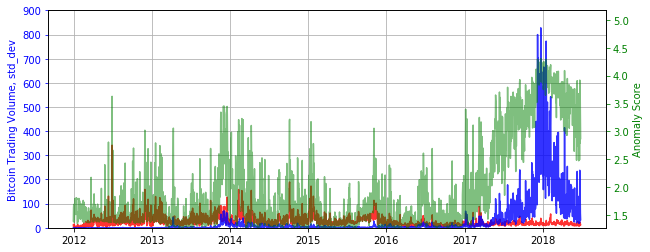

In [103]:
# Step 13: Plot the anomaly scores along with some features from the daily std_dev data

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#https://matplotlib.org/2.0.2/api/colors_api.html

ax1.plot(df_std['Volume_(BTC)'], color='r', alpha=0.8)
ax1.plot(df_std['High'], color='b', alpha=0.8)
ax2.plot(df_std['score'], color='g', alpha=0.5)

ax1.grid(which='major', axis='both')

ax1.set_ylabel('Bitcoin Trading Volume, std_dev', color='b')
ax2.set_ylabel('Anomaly Score', color='g')

ax1.tick_params('y', colors='b')
ax2.tick_params('y', colors='g')

ax1.set_ylim(0, 900)
ax2.set_ylim(min(scores), 1.2*max(scores))
fig.set_figwidth(10)


In [110]:
# Step 14: Anomalies are defined as scores greater than 2.5 standard deviations fronm the mean of score.

score_mean = df_std['score'].mean()
score_std = df_std['score'].std()
score_cutoff = score_mean + 2.5*score_std

anomalies = df_std[df_std['score'] > score_cutoff]
print("At a 2.5 sd threshhold, there are " + str(len(anomalies.score)) + " anomalies.")
anomalies.head()

At a 2.5 sd threshhold, there are 64 anomalies.


,Open,High,Low,Close,Volume_(BTC),Weighted_Price,score
Date,,,,,,,
2017-11-10,270.775122,269.239623,272.701042,270.860288,30.359165,271.221138,3.968146
2017-11-29,439.034644,439.275272,438.390802,438.765025,28.677102,438.987345,4.110264
2017-11-30,391.256976,386.221282,396.186670,391.279834,25.172844,391.314298,4.074991
2017-12-01,441.174596,440.255236,442.261882,441.682681,16.193333,441.956982,4.112052
2017-12-03,316.557264,315.828581,317.159655,316.114541,20.007064,315.913728,4.021990


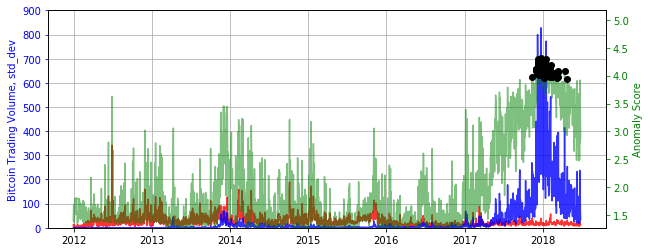

In [111]:
# Step 15: Add the anomalies to the plot.

ax2.plot(anomalies.index, anomalies.score, 'ko')
fig
# high anomaly scores are highly concentrated around the end of 2017/beginning of 2018.

In [112]:
sagemaker.Session().delete_endpoint(rcf_inference.endpoint)

INFO:sagemaker:Deleting endpoint with name: randomcutforest-2018-09-30-03-34-34-791


In [113]:
#Step 16:  We are now starting over with minute-level data, all 3.4 million of them
from sagemaker import RandomCutForest
df_subset = df[['Minute','Open', 'Close', 'High', 'Low', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price']]
df_subset = df_subset.set_index(pd.DatetimeIndex(df_subset['Minute']).values)
df_subset = df_subset.drop(columns = ['Minute'])
session = sagemaker.Session()

# specify general training job information
rcf_minute = RandomCutForest(role=execution_role,
                      train_instance_count=1,
                      train_instance_type='ml.c5.4xlarge',
                      data_location='s3://{}/{}/'.format(daves_bucket, daves_prefix),
                      output_path='s3://{}/{}/output'.format(daves_bucket, daves_prefix),
                      num_samples_per_tree=2048,
                      num_trees=1000)
# automatically upload the training data to S3 and run the training job
rcf_minute.fit(rcf_minute.record_set(df_subset.values))

INFO:sagemaker:Creating training-job with name: randomcutforest-2018-09-30-04-17-36-056


2018-09-30 04:17:36 Starting - Starting the training job...
Launching requested ML instances......
Preparing the instances for training...
2018-09-30 04:19:09 Downloading - Downloading input data
2018-09-30 04:19:17 Training - Downloading the training image..
Docker entrypoint called with argument(s): train
[09/30/2018 04:19:48 INFO 139624732972864] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_ftp_port': 8999, u'num_samples_per_tree': 256, u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'_kvstore': u'dist_async', u'force_dense': u'true', u'epochs': 1, u'num_trees': 100, u'eval_metrics': [u'accuracy', u'precision_recall_fscore'], u'_num_kv_servers': u'auto', u'mini_batch_size': 1000}
[09/30/2018 04:19:48 INFO 139624732972864] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'mini_batch_size': u'1000', u'feature_dim': u'7', u'num_samples_per_tree': u'


Training image download completed. Training in progress.[09/30/2018 04:19:54 INFO 139624732972864] Sampling training data completed.
#metrics {"Metrics": {"epochs": {"count": 1, "max": 1, "sum": 1.0, "min": 1}, "update.time": {"count": 1, "max": 5562.366962432861, "sum": 5562.366962432861, "min": 5562.366962432861}}, "EndTime": 1538281194.751225, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "RandomCutForest"}, "StartTime": 1538281189.188555}

[09/30/2018 04:19:54 INFO 139624732972864] Early stop condition met. Stopping training.
[09/30/2018 04:19:54 INFO 139624732972864] #progress_metric: host=algo-1, completed 100 % epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 3406, "sum": 3406.0, "min": 3406}, "Number of Batches Since Last Reset": {"count": 1, "max": 3406, "sum": 3406.0, "min": 3406}, "Number of Records Since Last Reset": {"count": 1, "max": 3405857, "sum": 3405857.0, "min": 3405857}, "Total Batches Seen": {"count": 1,

As it did at step 10, it will take a few minutes for the training instance to become available.

Building the model with the minute-level took about 10 minutes and 135 billable seconds.

In [114]:
# Step 17:  spin up endpoint instances for generating anamaly scores. 
# We're creatign a beefier endpoint to process the 3.4 million minute-level records

rcf_inference = rcf_minute.deploy(
    initial_instance_count=1,
    instance_type='ml.c5.4xlarge',
)

INFO:sagemaker:Creating model with name: randomcutforest-2018-09-30-04-22-34-842
INFO:sagemaker:Creating endpoint with name randomcutforest-2018-09-30-04-17-36-056


---------------------------------------------------------------!

In [115]:
# Step 18: define the file format for sending the data to the endpoint for inference calculations

from sagemaker.predictor import csv_serializer, json_deserializer

rcf_inference.content_type = 'text/csv'
rcf_inference.serializer = csv_serializer
rcf_inference.accept = 'application/json'
rcf_inference.deserializer = json_deserializer

In [117]:
# Step 19: generate anomaly scores using the endpoints.
# This section has been failing. Let's try breaking it up into 340 chunks of 10,000 records 

df_subset_numpy = df_subset.as_matrix()

from collections import defaultdict
results = defaultdict(list)

# this function splits the dataset into subsets of n records each
def get_every_n(a, n=2):
    for i in range((a.shape[0] // n) + 1):
        yield a[n*i:n*(i+1)]

for subset in get_every_n(df_subset_numpy,10000):
    subset_results = rcf_inference.predict(subset)
    for score in subset_results['scores']:
        results['scores'].append(score)

# reality check - how many scores did we generate?
print(len(results['scores']))

KeyboardInterrupt: 

In [116]:
# Step 20: With the anomaly scores in 'results', we now add them to the original dataframe, df_subset

scores = [datum['score'] for datum in results['scores']]

# add scores to minute-level data frame and print first few values
df_subset['score'] = pd.Series(scores, index=df_subset.index)
df_subset.head()

ConnectionClosedError: Connection was closed before we received a valid response from endpoint URL: "https://runtime.sagemaker.us-east-1.amazonaws.com/endpoints/randomcutforest-2018-09-30-04-17-36-056/invocations".

In [ ]:
# Step 21: Delete the endpoint(s). They're expensive.

sagemaker.Session().delete_endpoint(rcf_inference.endpoint)

We should show some visualizations of the anomaly scores for minute-level data, similar to the plots in step 13 and 15 above.